In [3]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [7]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()


start_t = time.time()
data_year = 2018
pdgId = 13
category = 0

if data_year == 2016:lumi = 35.92*1000 #in pb-1
elif data_year == 2017:lumi = 41.53 * 1000
else: lumi = 59.74 * 1000
data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/Data'+str(data_year)+'/v3/v8/normalized/'
mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIIFall18/v3/v8/normalized/'

bkg_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p9/MC_Summer16/v1/v3/normalized/'



if category == 0:
    fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p12_Data2018_17Sept2018_Run2018-HighMET-17Sep2018_goodLumi.root'
    fpath_bkg['mc'] = mc_path + 'ggH_HToSSTobbbb_ms55_pl1000_RunIIFall18_1pb_weighted.root'
#     fpath_bkg['QCDHT50toInf'] = bkg_path + 'QCD_HT50toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root'

    lumi = (1.287015729 + 6.941561868 + 3.227904890 + 31.312400879) * 1000 #v3/v8

elif category == 1:
    fpath_bkg['mc'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIIFall18/v3/v5/normalized/WH_HToSSTobbbb_ms55_pl10000_1pb_weighted.root'

#     if pdgId == 13:
#         fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p12_Data2018_SingleMuon_17Sept2018_Run2018D-ZMu-PromptReco-v2.root'
#     else:
#         fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p12_Data2018_EGamma_17Sept2018_Run2018D-ZElectron-PromptReco-v2.root'
    lumi = 31.34*1000
else:
    data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/Data'+str(data_year)+'/v2/v3/normalized/'
    mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIISummer16/v1/v2/signals/normalized/'
    fpath_bkg['mc'] = mc_path + 'ZH_HToSSTobbbb_ms55_pl1000_1pb_weighted.root'
    fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p12_Data2018_SingleMuon_17Sept2018_Run2018D-ZMu-PromptReco-v2_goodLumi.root'
    lumi = 29.516263349*1000
# if data_year == 2018:
#     fpath_bkg['SingleElectron'] = data_path + 'EGamma.root'
# else:
#     fpath_bkg['SingleElectron'] = data_path + 'SingleElectron.root'




NEvents = {}

NEvents_genweight = {}
for k,v in fpath_bkg.items():
    print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 
#     if k[:7] == 'ntuples':
#         tree_bkg[k] = root_dir['ntuples']['llp']
#         NEvents[k] = root_dir['ntuples']['NEvents'][1]
#     else:
    tree_bkg[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    NEvents_genweight[k] = root_dir['NEvents_genweight'][1]
#     tree[k] = root_dir['ntuples']
    a = tree_bkg[k]["weight"].array()
    print("NEvents",NEvents[k])
    print("NEvents_genweight",NEvents_genweight[k])


    print ('weights',np.unique(a)*lumi)
    print(np.sum(a))
    print(len(a))
#     print(len(a)/ NEvents[k])
#     print(a.shape)
print(time.time()-start_t)

data /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/Data2018/v3/v8/normalized/Run2_displacedJetMuonNtupler_V1p12_Data2018_17Sept2018_Run2018-HighMET-17Sep2018_goodLumi.root
NEvents 9339111.0
NEvents_genweight 0.0
weights [42768.883]
778527.0
778527
mc /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIIFall18/v3/v8/normalized/ggH_HToSSTobbbb_ms55_pl1000_RunIIFall18_1pb_weighted.root
NEvents 520800.0
NEvents_genweight 11183702.0
weights [-4.0306168 -3.9903104  3.9504073  3.9903104  4.0306168]
10.024069
107395
2.7884998321533203


# Load trigger

In [8]:
trigger_names_file = '/nfshome/christiw/llp/delayed_jet_analyzer/data/trigger_names_llp_v1.dat'
trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])
# if wH:
#     trigger_paths = [87,135,136] #PFMET120
# #     elif data_year == 2017: trigger_paths = [87,136] #PFMET120
# else:
trigger_paths = [177,362,87,135,136] #PFMET120
trigger_paths += [84,91]
if category == 0:
    trigger_paths = [310]
xsec = {}
xsec['bbbb10m'] = (5.328E-01 + 8.4E-01) *0.324
xsec['bbbb1m'] = (5.328E-01 + 8.4E-01) *0.324
xsec['bbbb0.1m'] = (5.328E-01 + 8.4E-01) *0.324


xsec['WJetsToLNu'] = 61526.7

legend = {}
legend['bbbb10m'] = 'signal c#tau = 10 m'
legend['bbbb1m'] = 'signal c#tau = 1 m'
legend['bbbb0.1m'] = 'signal c#tau = 0.1 m'

legend['SingleElectron'] = 'SingleElectron'
legend['SingleMuon'] = 'SingleMuon'
legend['WJetsToLNu'] = 'WJetsToLNu'

# Helper Functions

In [123]:
import math
def deltaPhi( phi1,  phi2):
    dphi = phi1-phi2
    while (dphi > math.pi):
        dphi -= 2*math.pi
    while (dphi <= -math.pi):
        dphi += 2*math.pi
    return dphi
def deltaR(eta1, phi1, eta2, phi2):
    dphi = deltaPhi(phi1,phi2)
    deta = eta1 - eta2
    return (dphi*dphi + deta*deta)**0.5

# nCsc with different hit vetoing

In [12]:
%%time

start_t = time.time()
JET_PT_CUT = 10
MUON_PT_CUT = 20


weight = {}
weight_event = {}
lumiSec = {}
evtNum = {}
nCsc = {}
npv = {}
npu = {}
runNum = {}
nCsc_JetMuonVetoCluster0p4_Me1112Veto = {}
gLLP_csc = {}
cscClusterSize = {}
cscClusterTime = {}
nCscClusters = {}
selections_cluster = {}
sel_cluster = {}
sel_jetveto = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
gen_angle = {}
nRechitClusters = {}
jetMet_dPhi = {}
jetMet_dPhiMin = {}
jetMet_dPhiMin4 = {}
# keys = ['data','mc_intime_bkg','mc_oot_bkg','mc_signal']
keys = ['data_intime','data_oot','mc_signal','mc_bkg']
keys = ['data_intime','data_oot','mc_signal',]
# keys = ['mc_signal']

# keys = ['mc_bkg']
# keys = ['mc_signal','mc_background']
# for k,T in tree_bkg.items():
for k in keys:
    if k == 'mc_bkg':
        T = tree_bkg['QCDHT50toInf']
    elif k[:2] == 'mc':
        T = tree_bkg['mc']
    else:
        T = tree_bkg['data']
    if pdgId == 13 and k == 'SingleElectron': continue
    if pdgId == 11 and k == 'SingleMuon': continue
        
########### SELECTION: CLUSTERS ############

    ###### OOT control region #####
    if not k == 'mc_bkg':
        sel_rechitcluster = T.array('cscRechitClusterMaxStationRatio') > 0.1
        sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterJetVetoPt') < JET_PT_CUT)
        sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterMuonVetoPt') < MUON_PT_CUT)
    #     sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterMe11Ratio') < 0.01)
    #     sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterMe12Ratio') < 0.01)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, np.abs(T.array('cscRechitClusterMaxChamber')) > 12)
    #     sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitClusterTime') < 22, T.array('cscRechitClusterTime') > -12.5))
        nRechitClusters[k] = sel_rechitcluster.sum()

        if k == 'mc_signal' or k == 'mc_background' or k == 'mc_intime_bkg' or k == 'data_intime':
            sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitClusterTime') < 12.5, T.array('cscRechitClusterTime') > -5.0))

        else:
            sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_or(T.array('cscRechitClusterTime') < -5.0, T.array('cscRechitClusterTime') > 12.5))

        print("sel_rechit",np.count_nonzero(sel_rechitcluster.flatten()))


    
########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()
    # select only triggered events
    sel_ev= np.ones(hlt[:,0].shape, dtype=bool)
    sel_ev= np.zeros(hlt[:,0].shape)
    for tr in trigger_paths:            
        sel_ev  = np.logical_or(sel_ev,hlt[:,tr])
        print("trigger",tr,1.0*np.count_nonzero(hlt[:,tr])/len(hlt[:,tr]))
    print(np.count_nonzero(sel_ev))
    sel_ev = np.logical_and(sel_ev, T.array('category') == category)
    sel_ev = np.logical_and(sel_ev,nRechitClusters[k] > 0)

    print(np.count_nonzero(sel_ev))

    if category == 0:
        sel_ev = np.logical_and(sel_ev,T.array('met') > 200)
        sel_ev = np.logical_and(sel_ev,T.array('nLeptons') == 0)
        sel_ev = np.logical_and(sel_ev, T.array('nJets') > 0)
#     if category == 1:
#         sel_ev = np.logical_and(sel_ev,np.abs(T.array('lepPdgId')).sum() == pdgId)
    if category == 2:
        sel_ev = np.logical_and(sel_ev,np.abs(T.array('lepPdgId')).sum() == 2*pdgId)
    print(np.count_nonzero(sel_ev))
    gLLP_csc[k] = T.array('gLLP_csc')
    if k == 'mc_signal':
        sel_ev = np.logical_and(sel_ev, np.sum(T.array('gLLP_csc'),axis = 1) > 0)
    print(np.count_nonzero(sel_ev))
#         print(np.count_nonzero(sel_ev)/NEvents['mc'])
    if k == 'mc_intime' or k =='mc_background':
        sel_ev = np.logical_and(sel_ev, np.sum(T.array('gLLP_csc'),axis = 1) == 0)
        decay_distance0 = np.sqrt(T.array('gLLP_decay_vertex_x')[:,0]**2 + T.array('gLLP_decay_vertex_y')[:,0]**2 + T.array('gLLP_decay_vertex_z')[:,0]**2)
        decay_distance1 = np.sqrt(T.array('gLLP_decay_vertex_x')[:,1]**2 + T.array('gLLP_decay_vertex_y')[:,1]**2 + T.array('gLLP_decay_vertex_z')[:,1]**2)
        cond1 = np.logical_and(decay_distance0 < 200, decay_distance1 < 200)
        cond2 = np.logical_and(np.abs(T.array('gLLP_decay_vertex_z')[:,0]) > 1200, np.abs(T.array('gLLP_decay_vertex_z')[:,1]) > 1200)
        sel_ev = np.logical_and(sel_ev, np.logical_or(cond1, cond2))
########### BRANCHES ############

   ##### event variables ##### 
    
    gLLP_beta[k] = T.array('gLLP_beta')[sel_ev]
    jetPt[k] = T.array('jetPt')[sel_ev]
    jetPhi[k] = T.array('jetPhi')[sel_ev]
#     genJetPt[k] = T.array('genJetPt')[sel_ev]
#     genJetPhi[k] = T.array('genJetPhi')[sel_ev]
#     genMet[k] = T.array('genMetPtTrue')[sel_ev]
#     genMetPhi[k] = T.array('genMetPhiTrue')[sel_ev]

    metPhi[k] = T.array('metPhi')[sel_ev]
    
  
    met_trigger[k] = hlt[:,310][sel_ev]
    met[k] = T.array('met')[sel_ev]
    jetMet_dPhiMin4[k] = T.array('jetMet_dPhiMin4')[sel_ev]
    jetMet_dPhiMin[k] = T.array('jetMet_dPhiMin')[sel_ev]
    jetMet_dPhi[k] = T.array('jetMet_dPhi')[sel_ev]
    weight[k] = T.array('weight')[sel_ev]
    if k[:2] == 'mc':
        weight[k] = weight[k]*lumi
    ##### clusters #####

    if not k == 'mc_bkg':
        cscClusterTime[k] = T.array('cscRechitClusterTime')[sel_rechitcluster][sel_ev]
        cscClusterSize[k] =  T.array('cscRechitClusterSize')[sel_rechitcluster][sel_ev]
        nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] = cscClusterSize[k].sum()
        nCscClusters[k] = cscClusterSize[k].count()
    
#     print(np.count_nonzero(sel_ev),len(sel_ev))
    print(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k].sum(),len(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]))
    print(k)


sel_rechit 57683
trigger 310 0.7347580751855748
572029
93638
86981
86981
1451724 86981
data_intime
sel_rechit 165834
trigger 310 0.7347580751855748
572029
93638
86981
86981
4245937 86981
data_oot
sel_rechit 49800
trigger 310 0.02162111830159691
2322
1224
368
267
126579 267
mc_signal
CPU times: user 12.8 s, sys: 1.11 s, total: 14 s
Wall time: 13.5 s


## trigger efficiency

CPU times: user 96.9 ms, sys: 31.6 ms, total: 129 ms
Wall time: 127 ms


Warning in <TROOT::Append>: Replacing existing TH1: mc_signal (Potential memory leak).


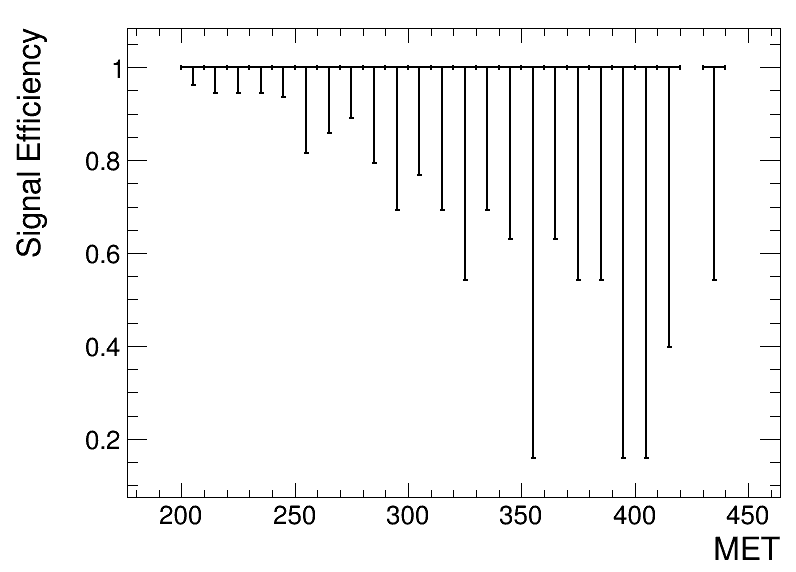

In [13]:
%%time 

c = rt.TCanvas('c','c', 800, 600)
h = {}
leg = rt.TLegend(0.4,0.20,0.9,0.4)
leg.SetTextSize(0.03)

leg.SetBorderSize(0)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
k = 'mc_signal'
# print(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k])
xaxis = met[k]
xaxis_title = 'MET'
bins = [50,0,500]


# xaxis = nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]
# xaxis_title = 'N_{rechit}'
# bins = [50,0,3000]
# print(xaxis)
hm = create_TH1D( xaxis[met_trigger[k]], axis_title=[xaxis_title, 'Signal Efficiency'], name=k, binning=bins)
hb = create_TH1D( xaxis, axis_title=[xaxis_title, 'Signal Efficiency'], name=k, binning=bins)
pEff1= rt.TEfficiency(hm,hb)
pEff1.SetLineColor(std_color_list[0])
pEff1.SetLineWidth(2)
pEff1.Draw()
# leg.AddEntry(pEff1[str(th_wire)], name+' cut = '+str(th_wire)+", bkg rejection = "+str(round(bkg_rej[i],2)))
# leg.Draw()
c.Draw()


    

In [18]:
# 2D histogram

106
[ 51  76  56 ...  65 110  74]
0.13563871383666992


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


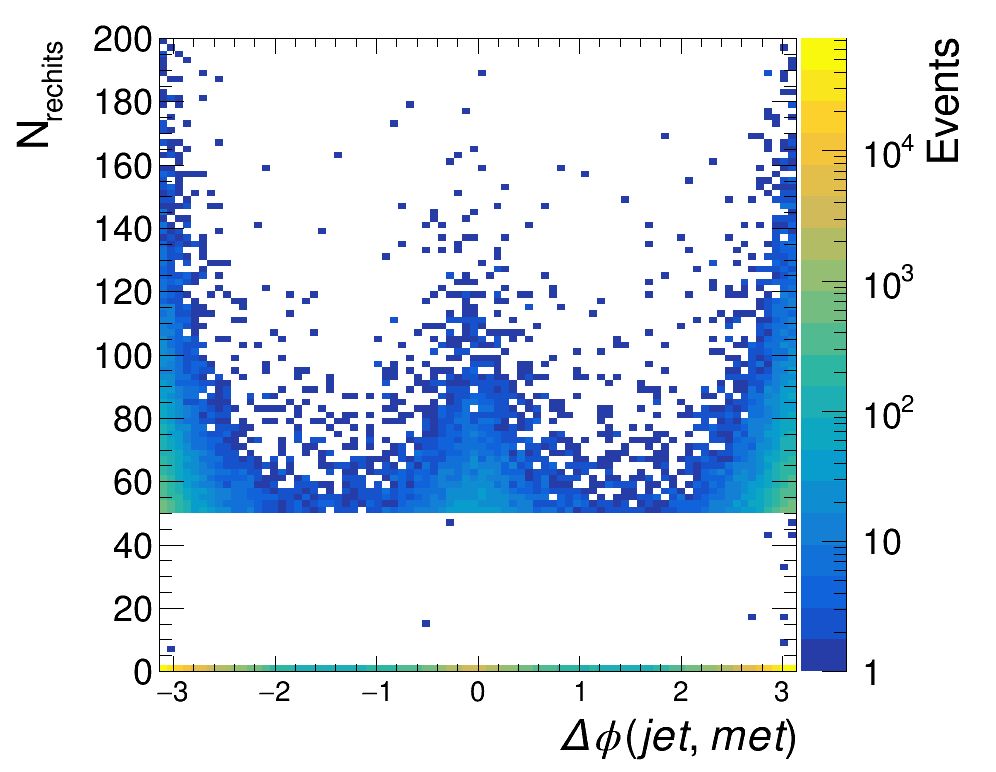

In [110]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

i = 0
k = 'data_intime'
if k == 'data_intime':
    cond = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < 200,jetPt[k].count()>0)
else:
    cond = jetPt[k].count()>0
# h[k] = create_TH2D(np.column_stack((angle[k][cond],jetPt[k][cond][:,0])), axis_title = ['\Delta\phi (jet,met)','jet p_{T}[GeV]','Events'], binning=[80,-3.14,3.14,100,0,2000])
h[k] = create_TH2D(np.column_stack((angle[k][cond],nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][cond])), axis_title = ['\Delta\phi (jet,met)','N_{rechits}','Events'], binning=[80,-3.14,3.14,100,0,200])
# h[k] = create_TH2D(np.column_stack((gen_angle[k],genJetPt[k][:,0])), axis_title = ['\Delta\phi (jet,met)','jet p_{T}[GeV]','Events'], binning=[80,-3.14,3.14,100,0,2000])
# h[k] = create_TH2D(np.column_stack((nCscClusters[k][cond],nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][cond])), axis_title = ['N_{clusters}','N_{rechits}','Events'], binning=[3,0,3,100,0,100])
print(np.count_nonzero(nCscClusters[k][cond]>1))
print(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][nCscClusters[k]==1])
# h[k] = create_TH2D(np.column_stack((met[k],nCsc_JetMuonVetoCluster0p4_Me1112Veto[k])), axis_title = ['met[GeV]','N_{rechits}','Events'], binning=[50,0,500,50,0,3000])
# h[k] = create_TH2D(np.column_stack((met[k],jetPt[k].count())), axis_title = ['met[GeV]','N_{jets}','Events'], binning=[50,0,500,10,0,10])
# h[k] = h[k].ProfileY()
h[k].GetXaxis().SetLabelSize(0.04)




h[k].SetLineColor(std_color_list[i])
# leg.AddEntry(h[k], k)
#     h[k].SetMaximum(10E5)
#     h[k].SetMinimum(1)
h[k].Draw('colz')
c.SetRightMargin(0.2)



# if setlog: 
c.SetLogz()
c.Draw()
print(time.time()-start_t)

# Data plot

weight 1.0
weight 1.0
3.0588676064253266
0.3333333333333333
0.3283419391853127
0.3258406680207628
0.3273509067115349
0.34146341463414637
0.3439153439153439
0.4140127388535032
0.3769230769230769
0.3717948717948718
weight 4.0306168


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


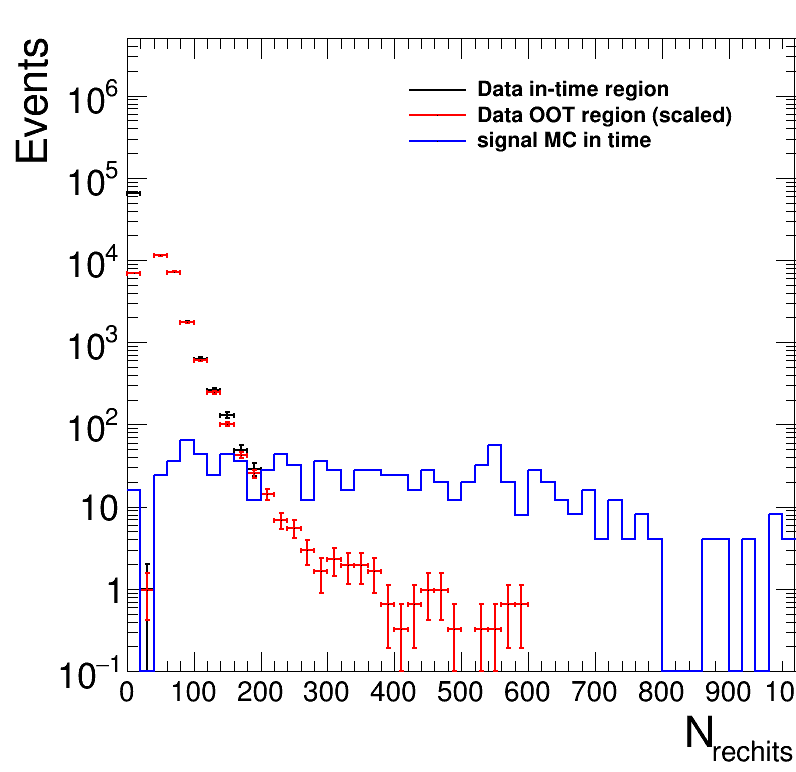

In [17]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.5,0.80,0.90,0.90)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()

legend = {}
legend['data_oot'] = 'Data OOT region'
legend['data_intime'] = 'Data in-time region'
legend['mc_signal'] = 'signal MC in time'
legend['mc_intime'] = 'MC in-time background'
legend['mc_oot'] = 'MC OOT background'
legend['mc_bkg'] = 'QCD 50toInf background'




keys = ['data_intime','data_oot','mc_signal',]
# keys = ['data_intime','mc_signal','']


h = {}
rt.gStyle.SetOptFit(1011)
# for i,k in enumerate(tree_bkg.keys()):
br = 1
for i,k in enumerate(keys):
#     w = cscClusterNLayer[k]*0.0 + weight[k]
#     print(len(w.flatten()))
#     print(len(cscClusterNLayer[k].flatten()))
#     if not k == 'mc_signal':continue
#     if not k == 'mc_signal':continue
#     if k == 'data_oot':continue
#     if k == 'mc_bkg': continue
    if k == 'data_intime':
        cond = nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < 200
    else:
        cond = np.ones(weight[k].shape, dtype=bool)
 
    if k == 'mc_signal':
        br = 1
    else: br = 1
#     if k == 'mc_background':br = 1
    bins = [50,0,1000]
    metcut = 200
    h[k] = create_TH1D( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][cond], axis_title=['N_{rechits}', 'Events'], name=k, binning=bins,weights = br*weight[k][cond])
#     h[k+'met'] = create_TH1D( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][met[k]>metcut], axis_title=['N_{rechits}', 'Events'], name=k, binning=bins,weights = weight[k][met[k]>metcut])
#     h[k] = create_TH1D( angle[k][cond], axis_title=['\Delta \phi(MET,jet)', 'Events'], name=k, binning=[50,-3.2,3.2],weights = weight[k][cond])

#     h[k] = create_TH1D( cscClusterTime[k][:,0], axis_title=['csc cluster time [ns]', 'Events'], name=k, binning=[30,-100,-12.5],weights = weight[k])
    h[k].SetLineColor(std_color_list[i])
#     h[k+'met'].SetLineColor(std_color_list[i+1])
#     h[k+'met'].SetLineStyle(2)
    print("weight",weight[k][0])
#     leg.AddEntry(h[k+'met'], "OOT "+k+' with met trigger')
    leg.AddEntry(h[k], legend[k]+" (scaled)" if k == 'data_oot' else legend[k])
#     print(k,"events after 200: ",np.sum(weight[k]))
#     print(k,"events after 200: ",np.sum(weight[k][nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=500]))
#     if k == 'mc_signal':
#         for i in range(h[k].GetNbinsX()):
#             s = 0.015*h[k].GetBinContent(i+1)
#             b = h['data_oot'].GetBinContent(i+1)
#             if s+b == 0:continue
#             sig = s/(s+b)**0.5
#             print(i,h[k].GetBinCenter(i+1),sig,s,b)
#             if sig < 1./100:
#                 print(i,sig)
#                 continue
#     h[k].SetMinimum(1)

#     r = h[k].Fit('expo', 'LRSQ+', '', 50,400)
#     print(r.Get())
#     print(r.Prob())
#     h[k].GetFunction("expo").SetLineColor(std_color_list[2])
#     h[k].GetFunction("expo").SetLineWidth(2)
    h[k].GetXaxis().SetLabelSize(0.04)
    h[k].SetMinimum(0.1)
    h[k].SetMaximum(10E6/2)
#     h[k+'met'].GetXaxis().SetLabelSize(0.02)
    if k == 'data_oot':
        scale = 1.0*h['data_intime'].GetBinContent(4)/h['data_oot'].GetBinContent(4)
        for i in range(10):
            print(1.0*h['data_intime'].GetBinContent(i+1)/h['data_oot'].GetBinContent(i+1))
        h[k].Scale(scale)
    if k[:4] == 'data':
        h[k].Draw('same E1')
    else:
        h[k].Draw("same hist")
#     h[k+'met'].DrawNormalized('same')
    

# c = make_ratio_plot([h['mc'],h['data']], fit = False, logy=True, in_tags = ["MC","Data"], ratio_bounds = [0,3])
c.SetRightMargin(0)
c.SetLogy()
leg.Draw()

c.Draw()
# print(time.time()-start_t)

## significance

0.7138335704803467


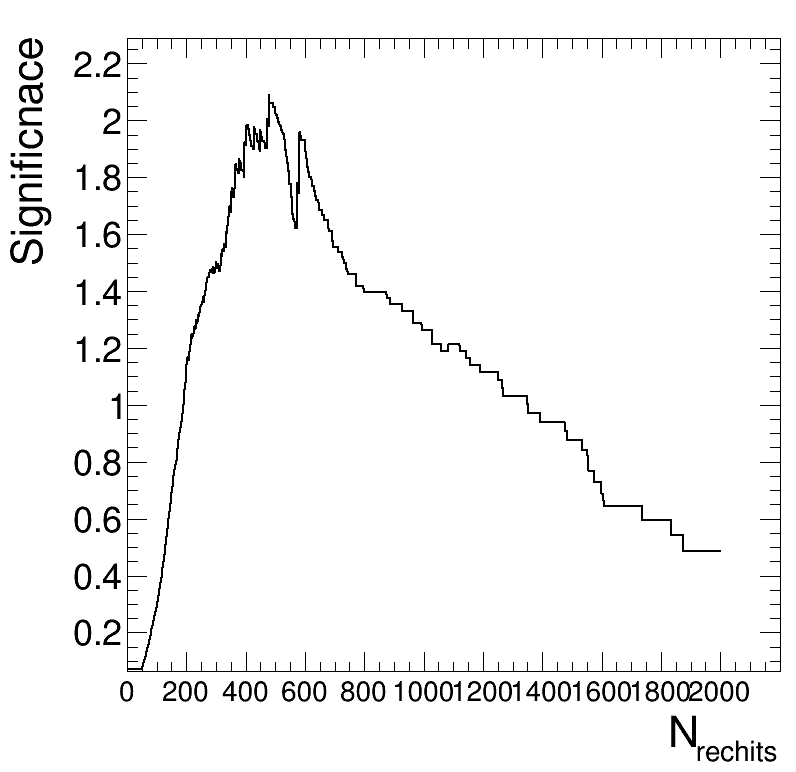

In [87]:
start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.35,0.80,0.85,0.92)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)

var = [nCsc_JetMuonVetoCluster0p4_Me1112Veto,]
name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto',]
legend = [ 'jet & muon veto + ME11/12 veto',]

bkg_k = 'data_oot'
sig_k = 'mc_signal'
br = 0.02

threshold = list(range(300))
threshold = np.array(list(range(2000)))
# print(threshold)
for i in range(len(var)):
    event_count = {}
    
    for k in ['data_oot','mc_signal']:
        event_count[k] = []
        for th in threshold:
            event_count[k].append(np.sum(weight[k][var[i][k]>th]))
        event_count[k] = np.array(event_count[k])
        if k == sig_k:
            event_count[k] = event_count[k]*br
    sig = event_count[sig_k]/np.sqrt(event_count[sig_k]+event_count[bkg_k])
    cond = event_count[sig_k]>0
    sig = sig[cond]
    ncsc = threshold[cond]
#     gr['bbbb'] = create_TGraph(eff_bkg,eff_sig,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    h[sig_k+str(i)] = create_TGraph(ncsc, sig,  axis_title=['N_{rechits}', 'Significnace'])
#     h[sig_k+str(i)] = create_TGraph(ncsc, event_count[sig_k],  axis_title=['N_{rechits}', 'Event Yield'])

    h[sig_k+str(i)].SetLineWidth(2)
    h[sig_k+str(i)].SetMarkerColor(std_color_list[i])
    h[sig_k+str(i)].SetLineColor(std_color_list[i])
    h[sig_k+str(i)].GetXaxis().SetRangeUser(0, 3000)
    h[sig_k+str(i)].GetXaxis().SetLabelSize(0.04)

#     h[sig_k+str(i)].GetYaxis().SetRangeUser(0, 3)


    leg.AddEntry(h[sig_k+str(i)],sig_k+" "+legend[i])
    h[sig_k+str(i)].Draw('ac' if i == 0 else 'c')

#     h[sig_k+str(i)].Draw('ac' if i==0 else 'c')
#     gr['bbbb'].Draw('')




# c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

print(time.time()-start_t)


# Other quantities

mc_bkg weight 22.924406
2083
angle 2083


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


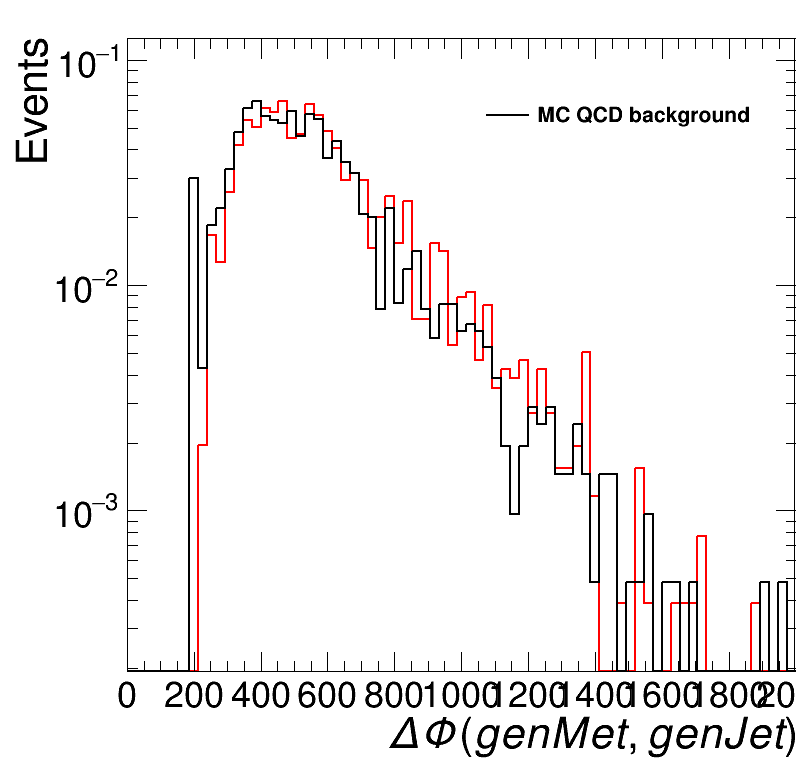

In [132]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.6,0.80,0.90,0.90)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()

legend = {}
legend['data_oot'] = 'Data OOT region'
legend['data_intime'] = 'Data in-time region'
legend['mc_signal'] = 'signal MC in time'
legend['mc_intime'] = 'MC in-time background'
legend['mc_oot'] = 'MC OOT background'
legend['mc_bkg'] = 'MC QCD background'


h = {}
rt.gStyle.SetOptFit(1011)
# for i,k in enumerate(tree_bkg.keys()):
br = 1
for i,k in enumerate(keys):
#     w = cscClusterNLayer[k]*0.0 + weight[k]
#     print(len(w.flatten()))
#     print(len(cscClusterNLayer[k].flatten()))
#     if not k == 'mc_signal':continue
#     if not k == 'mc_signal': continue
    
#     if k == 'mc_background':br = 1
   
    bins = [10,0,10]
    metcut = 200
    if k == 'data_oot': continue
#     if k[:4] == 'data':
#         cond = nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < 100
#         print(k,1.0*np.count_nonzero(cond)/len(cond))
#     else:
#         cond = np.ones(weight[k].shape, dtype=bool)

#     cond = np.logical_and(cond, abs(angle[k])<1)
    
#     h[k] = create_TH1D( nLeptons[k][cond], axis_title=['N_{lep}', 'Events'], name=k, binning=bins)

    h[k] = create_TH1D( jetPt[k].count()[cond], axis_title=['N_{jets}', 'Events'], name=k, binning=bins)
    h[k] = create_TH1D( jetPt[k][np.logical_and(cond, jetPt[k].count()>0)][:,0], axis_title=['jet p_{T} [GeV]', 'Events'], name=k, binning=[50,0,2500],weights = weight[k][[np.logical_and(cond, jetPt[k].count()>0)]])
    h[k] = create_TH1D( genJetPt[k][abs(gen_angle[k])<1][:,0], axis_title=['\Delta\Phi (genMet,genJet)', 'Events'], name=k, binning=[75,0,2000],weights = weight[k][abs(gen_angle[k])<1])
    h[k+'1'] = create_TH1D( genJetPt[k][abs(gen_angle[k])>1][:,0], axis_title=['\Delta\Phi (genMet,genJet)', 'Events'], name=k, binning=[75,0,2000],weights = weight[k][abs(gen_angle[k])>1])
#     h[k+'1'] = create_TH1D( genJetPt[k][abs(gen_angle[k])>1][:,0], axis_title=['\Delta\Phi (genMet,genJet)', 'Events'], name=k, binning=[75,0,2000],weights = weight[k][abs(gen_angle[k])>1])

    if k == 'mc_signal': 
        print(k,"pt cut",np.sum(weight[k][jetPt[k].count()>0][jetPt[k][jetPt[k].count()>0][:,0]>50]/np.sum(weight[k])))

#     h[k] = create_TH1D( angle[k][cond], axis_title=['\Delta \phi(MET,jet)', 'Events'], name=k, binning=[50,-4,4],weights = weight[k][cond])
    print(k,"weight",weight[k][0])
    print(len(angle[k][cond]))
#     h[k] = create_TH1D(met[k], axis_title=['N_{jets}', 'Events'], name=k, binning=[50,0,500])

    print("angle",len(angle[k]))
#     h[k+'met'] = create_TH1D( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][met[k]>metcut], axis_title=['N_{rechits}', 'Events'], name=k, binning=bins,weights = weight[k][met[k]>metcut])

#     h[k] = create_TH1D( cscClusterTime[k][:,0], axis_title=['csc cluster time [ns]', 'Events'], name=k, binning=[30,-100,-12.5],weights = weight[k])
    h[k].SetLineColor(std_color_list[i])
    h[k+'1'].SetLineColor(std_color_list[i+1])
    leg.AddEntry(h[k], legend[k]+" (scaled)" if k == 'data_oot' else legend[k])
#     print(k,"events after 200: ",np.sum(weight[k][nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=0])*br)
    h[k].SetMaximum(10E4)
    h[k].SetMinimum(0.1)


#     r = h[k].Fit('expo', 'LRSQ+', '', 50,400)
#     print(r.Get())
#     print(r.Prob())
#     h[k].GetFunction("expo").SetLineColor(std_color_list[2])
#     h[k].GetFunction("expo").SetLineWidth(2)
    h[k].GetXaxis().SetLabelSize(0.04)
    h[k+'1'].DrawNormalized('same hist')
    h[k].DrawNormalized('same hist')
    

c.SetRightMargin(0)
c.SetLogy()
leg.Draw()

c.Draw()
# print(time.time()-start_t)

40 419359.0
80 24500.0
120 3272.0
200 581.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: data_intime (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data_intime (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data_intime (Potential memory leak).


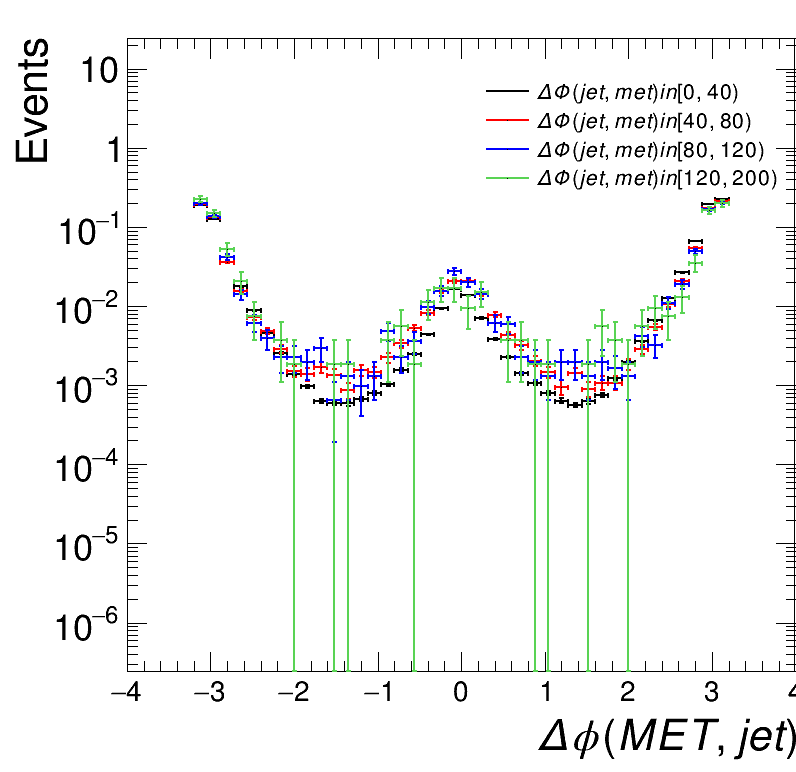

In [106]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.6,0.75,0.90,0.90)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()

legend = {}
legend['data_oot'] = 'Data OOT region'
legend['data_intime'] = 'Data in-time region'
legend['mc_signal'] = 'signal MC in time'
legend['mc_intime'] = 'MC in-time background'
legend['mc_oot'] = 'MC OOT background'
legend['mc_bkg'] = 'MC QCD background'


h = {}
rt.gStyle.SetOptFit(1011)
# for i,k in enumerate(tree_bkg.keys()):
br = 1
k = 'data_intime'
previous_cut = 0
for i,cut in enumerate([0,40,80,120,200]):
# for i, cut in enumerate([-1,1,3.14]):
#     w = cscClusterNLayer[k]*0.0 + weight[k]
#     print(len(w.flatten()))
#     print(len(cscClusterNLayer[k].flatten()))
#     if not k == 'mc_signal':continue
#     if not k == 'mc_signal': continue
    
#     if k == 'mc_background':br = 1
   
    bins = [10,0,10]
    metcut = 200
    if i == 0:
        continue
        cond = nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] <= cut
#         cond = angle[k]<=cut
    else:
        cond = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < cut, nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= previous_cut)
#         cond = np.logical_and(angle[k] <= cut, angle[k] > previous_cut)

    print(cut,np.sum(weight[k][cond]))
#     h[k] = create_TH1D( nLeptons[k][cond], axis_title=['N_{lep}', 'Events'], name=k, binning=bins)

#     h[str(i)] = create_TH1D( jetPt[k].count()[cond], axis_title=['N_{jets}', 'Events'], name=k, binning=[15,0,15])
#     h[str(i)] = create_TH1D( jetPt[k][np.logical_and(cond, jetPt[k].count()>0)][:,0], axis_title=['jet p_{T} [GeV]', 'Events'], name=k, binning=[50,0,2500],weights = weight[k][[np.logical_and(cond, jetPt[k].count()>0)]])

    h[str(i)] = create_TH1D( angle[k][cond], axis_title=['\Delta \phi(MET,jet)', 'Events'], name=k, binning=[50,-4,4],weights = weight[k][cond])
    h[str(i)].SetLineColor(std_color_list[i-1])
    leg.AddEntry(h[str(i)], "\Delta \Phi (jet,met) in [%(first)d,%(second)d)"%{"first":previous_cut,"second":cut})

#     leg.AddEntry(h[str(i)], "N_{rechits} in (%(first)d,%(second)d]"%{"first":previous_cut,"second":cut})
    previous_cut = cut

#     print(k,"events after 200: ",np.sum(weight[k][nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=0])*br)
    h[str(i)].SetMaximum(10E6)
    h[str(i)].SetMinimum(0.1)


#     r = h[k].Fit('expo', 'LRSQ+', '', 50,400)
#     print(r.Get())
#     print(r.Prob())
#     h[k].GetFunction("expo").SetLineColor(std_color_list[2])
#     h[k].GetFunction("expo").SetLineWidth(2)
    h[str(i)].GetXaxis().SetLabelSize(0.04)
    h[str(i)].DrawNormalized('same E1')
    

c.SetRightMargin(0)
c.SetLogy()
leg.Draw()

c.Draw()
# print(time.time()-start_t)

# third

In [ ]:
start_t = time.time()
pdgId = 13
JET_PT_CUT = 10
MUON_PT_CUT = 20


weight = {}
weight_event = {}
lumiSec = {}
evtNum = {}
nCsc = {}
npv = {}
npu = {}
runNum = {}
nCsc_JetMuonVetoCluster0p4_Me1112Veto = {}

cscClusterSize = {}

selections_cluster = {}
sel_cluster = {}
sel_jetveto = {}
for k,T in tree_bkg.items():
    if pdgId == 13 and k == 'SingleElectron': continue
    if pdgId == 11 and k == 'SingleMuon': continue
########### SELECTION: CLUSTERS ############

    ###### OOT control region #####
#     sel_cluster_temp = T.array('cscClusterMaxLayerRatio')*T.array('cscClusterSize') > 5.01
    sel_cluster_temp = T.array('cscClusterMaxStationRatio')*T.array('cscClusterSize') > 5.01



#     sel_cluster_temp = T.array('cscClusterJetVeto') < JET_PT_CUT
# #     sel_cluster_temp = np.logical_and( sel_cluster_temp, T.array('cscClusterMuonVeto') < MUON_PT_CUT)
    sel_cluster_temp = np.logical_and( sel_cluster_temp, T.array('cscClusterMe11Ratio') < 0.01)
    sel_cluster_temp = np.logical_and( sel_cluster_temp, T.array('cscClusterMe12Ratio') < 0.01)



#     sel_cluster_temp = np.logical_and( sel_cluster_temp, T.array('cscClusterMe1112Ratio') < 0.01)
#     sel_cluster_temp = np.logical_and(sel_cluster_temp, T.array('cscClusterMaxLayerRatio')*T.array('cscClusterSize') > 5.01)
    print("here")
    print(time.time()-start_t)
    
#     selections_cluster['test'] = np.logical_and(sel_cluster_temp, T.array('cscClusterTime') < -53)
#     selections_cluster['test'] = np.logical_and(selections_cluster['test'], T.array('cscClusterTime') > -87.5)
    
#     selections_cluster['oot1'] = np.logical_and(sel_cluster_temp, T.array('cscClusterTime') < -28)
#     selections_cluster['oot1'] = np.logical_and(selections_cluster['oot1'], T.array('cscClusterTime') > -62.5)
    
#     selections_cluster['oot2'] = np.logical_and(sel_cluster_temp, T.array('cscClusterTime') < -12.5)
#     selections_cluster['oot2'] = np.logical_and(selections_cluster['oot2'], T.array('cscClusterTime') > -37.5)

    selections_cluster['oot3'] = np.logical_and(sel_cluster_temp, T.array('cscClusterTime') < 72)
    selections_cluster['oot3'] = np.logical_and(selections_cluster['oot3'], T.array('cscClusterTime') > 37.5)
    
#     selections_cluster['oot4'] = np.logical_and(sel_cluster_temp, T.array('cscClusterTime') < 97)
#     selections_cluster['oot4'] = np.logical_and(selections_cluster['oot4'], T.array('cscClusterTime') > 62.5)
    


    sel_cluster = selections_cluster['oot3'] 
#     sel_cluster = sel_cluster_temp

    print("here")
    print(time.time()-start_t)

    hlt = T['HLTDecision'].array()
    # select only triggered events
    sel_ev= np.ones(hlt[:,0].shape, dtype=bool)
    sel_ev= np.zeros(hlt[:,0].shape)
    for tr in trigger_paths:            
        sel_ev  = np.logical_or(sel_ev,hlt[:,tr])
    sel_muon = np.logical_and(T.array('lepPassId'), T.array('lepPt')>=25)
    sel_muon = np.logical_and(sel_muon, np.abs(T.array('lepEta'))<2.4)
    sel_muon = np.logical_and(sel_muon, np.abs(T.array('lepPdgId')) == 13)

    sel_ele = np.logical_and(T.array('lepPassId'), T.array('lepPt')>=35)
    sel_ele = np.logical_and(sel_ele, np.abs(T.array('lepEta'))<2.4)
    sel_ele = np.logical_and(sel_ele, np.abs(T.array('lepPdgId')) == 11)
    
#     sel_lep = np.logical_or(sel_ele, sel_muon)
    if pdgId == 13:
        sel_lep = sel_muon
    else: 
        sel_lep = sel_ele
    sel_ev = np.logical_and(sel_ev, sel_lep.sum() == 1)
    ##### jet veto #####
    sel_jetveto = np.logical_and(sel_ev, (sel_cluster.sum()) >= 1)
    
    print("here")
    print(time.time()-start_t)

    cscClusterSize[k] =   T.array('cscClusterSize')[sel_cluster][sel_jetveto]
    if k[:6] == 'Single' or k == 'EGamma':
        weight[k] = T.array('weight')[sel_jetveto]
    else:
        weight[k] = T.array('weight')[sel_jetveto]*lumi


    nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] = cscClusterSize[k].sum()
    print(k)
print(time.time()-start_t)

# ROC Curve

In [ ]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()

h = {}
rt.gStyle.SetOptFit(1011)
if pdgId == 13: data = 'SingleMuon'
else: data = 'SingleElectron'
mc = 'WJetsToLNu'
keys = [data]
for i,k in enumerate(keys):
#     w = cscClusterNLayer[k]*0.0 + weight[k]
#     print(len(w.flatten()))
#     print(len(cscClusterNLayer[k].flatten()))
#     h[k] = create_TH1D( cscClusterNLayer[k].flatten(), axis_title=['cluster station', 'Events'], name=k, binning=[10,0,10],weights = w.flatten())
#     h[k] = create_TH1D( nCscClusters[k], axis_title=['Number of Clusters', 'Events'], name=k, binning=[10,0,10],weights = weight[k])

#     h[k] = create_TH1D( cscClusterNLayer[k].sum(), axis_title=['Number of Stations per Event', 'Events'], name=k, binning=[10,0,10],weights = weight[k])
    print(np.sum(weight[k]))

#     print(len(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]))
    h[k] = create_TH1D( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], axis_title=['nCSCSegments', 'Events'], name=k, binning=[20,0,100],weights = weight[k])
#     h[k] = create_TH1D( cscClusterTime[k][:,0], axis_title=['csc cluster time [ns]', 'Events'], name=k, binning=[30,-100,-12.5],weights = weight[k])

    h[k].SetLineColor(std_color_list[i])
#     leg.AddEntry(h[k], legend[k])
#     h[k].SetMinimum(1)

    if k == data:
        r = h[k].Fit('expo', 'LRSQ+', '', 15,60)
        print(r.Get())
        print(r.Prob())
        h[k].GetFunction("expo").SetLineColor(std_color_list[2])
        h[k].GetFunction("expo").SetLineWidth(2)
    h[k].Draw('E1')
# c = make_ratio_plot([h[mc],h[data]], fit = True, logy=True, in_tags = ["MC","Data"], ratio_bounds = [0,3])
# c.SetRightMargin(0)
c.SetLogy()


c.Draw()
# print(time.time()-start_t)

# 4th

In [ ]:
start_t = time.time()
pdgId = 13
JET_PT_CUT = 10
MUON_PT_CUT = 20


weight = {}
weight_event = {}
lumiSec = {}
evtNum = {}
nCsc = {}
npv = {}
npu = {}
runNum = {}
nCsc_JetMuonVetoCluster0p4_Me1112Veto = {}

cscClusterSize = {}

selections_cluster = {}
sel_cluster = {}
sel_jetveto = {}
for k,T in tree_bkg.items():
    if pdgId == 13 and k == 'SingleElectron': continue
    if pdgId == 11 and k == 'SingleMuon': continue
########### SELECTION: CLUSTERS ############

    ###### OOT control region #####
#     sel_cluster_temp = T.array('cscClusterMaxLayerRatio')*T.array('cscClusterSize') > 5.01
    sel_cluster_temp = T.array('cscClusterMaxStationRatio')*T.array('cscClusterSize') > 5.01



#     sel_cluster_temp = T.array('cscClusterJetVeto') < JET_PT_CUT
# #     sel_cluster_temp = np.logical_and( sel_cluster_temp, T.array('cscClusterMuonVeto') < MUON_PT_CUT)
    sel_cluster_temp = np.logical_and( sel_cluster_temp, T.array('cscClusterMe11Ratio') < 0.01)
    sel_cluster_temp = np.logical_and( sel_cluster_temp, T.array('cscClusterMe12Ratio') < 0.01)



#     sel_cluster_temp = np.logical_and( sel_cluster_temp, T.array('cscClusterMe1112Ratio') < 0.01)
#     sel_cluster_temp = np.logical_and(sel_cluster_temp, T.array('cscClusterMaxLayerRatio')*T.array('cscClusterSize') > 5.01)
    print("here")
    print(time.time()-start_t)
    
#     selections_cluster['test'] = np.logical_and(sel_cluster_temp, T.array('cscClusterTime') < -53)
#     selections_cluster['test'] = np.logical_and(selections_cluster['test'], T.array('cscClusterTime') > -87.5)
    
#     selections_cluster['oot1'] = np.logical_and(sel_cluster_temp, T.array('cscClusterTime') < -28)
#     selections_cluster['oot1'] = np.logical_and(selections_cluster['oot1'], T.array('cscClusterTime') > -62.5)
    
#     selections_cluster['oot2'] = np.logical_and(sel_cluster_temp, T.array('cscClusterTime') < -12.5)
#     selections_cluster['oot2'] = np.logical_and(selections_cluster['oot2'], T.array('cscClusterTime') > -37.5)

    selections_cluster['oot3'] = np.logical_and(sel_cluster_temp, T.array('cscClusterTime') < 72)
    selections_cluster['oot3'] = np.logical_and(selections_cluster['oot3'], T.array('cscClusterTime') > 37.5)
    
    selections_cluster['oot4'] = np.logical_and(sel_cluster_temp, T.array('cscClusterTime') < 97)
    selections_cluster['oot4'] = np.logical_and(selections_cluster['oot4'], T.array('cscClusterTime') > 62.5)
    


    sel_cluster = selections_cluster['oot4'] 
#     sel_cluster = sel_cluster_temp

    print("here")
    print(time.time()-start_t)

    hlt = T['HLTDecision'].array()
    # select only triggered events
    sel_ev= np.ones(hlt[:,0].shape, dtype=bool)
    sel_ev= np.zeros(hlt[:,0].shape)
    for tr in trigger_paths:            
        sel_ev  = np.logical_or(sel_ev,hlt[:,tr])
    sel_muon = np.logical_and(T.array('lepPassId'), T.array('lepPt')>=25)
    sel_muon = np.logical_and(sel_muon, np.abs(T.array('lepEta'))<2.4)
    sel_muon = np.logical_and(sel_muon, np.abs(T.array('lepPdgId')) == 13)

    sel_ele = np.logical_and(T.array('lepPassId'), T.array('lepPt')>=35)
    sel_ele = np.logical_and(sel_ele, np.abs(T.array('lepEta'))<2.4)
    sel_ele = np.logical_and(sel_ele, np.abs(T.array('lepPdgId')) == 11)
    
#     sel_lep = np.logical_or(sel_ele, sel_muon)
    if pdgId == 13:
        sel_lep = sel_muon
    else: 
        sel_lep = sel_ele
    sel_ev = np.logical_and(sel_ev, sel_lep.sum() == 1)
    ##### jet veto #####
    sel_jetveto = np.logical_and(sel_ev, (sel_cluster.sum()) >= 1)
    
    print("here")
    print(time.time()-start_t)

    cscClusterSize[k] =   T.array('cscClusterSize')[sel_cluster][sel_jetveto]
    if k[:6] == 'Single' or k == 'EGamma':
        weight[k] = T.array('weight')[sel_jetveto]
    else:
        weight[k] = T.array('weight')[sel_jetveto]*lumi


    nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] = cscClusterSize[k].sum()
    print(k)
print(time.time()-start_t)

# nCsc histogram

In [ ]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()

h = {}
rt.gStyle.SetOptFit(1011)
if pdgId == 13: data = 'SingleMuon'
else: data = 'SingleElectron'
mc = 'WJetsToLNu'
keys = [data]
for i,k in enumerate(keys):
#     w = cscClusterNLayer[k]*0.0 + weight[k]
#     print(len(w.flatten()))
#     print(len(cscClusterNLayer[k].flatten()))
#     h[k] = create_TH1D( cscClusterNLayer[k].flatten(), axis_title=['cluster station', 'Events'], name=k, binning=[10,0,10],weights = w.flatten())
#     h[k] = create_TH1D( nCscClusters[k], axis_title=['Number of Clusters', 'Events'], name=k, binning=[10,0,10],weights = weight[k])

#     h[k] = create_TH1D( cscClusterNLayer[k].sum(), axis_title=['Number of Stations per Event', 'Events'], name=k, binning=[10,0,10],weights = weight[k])
    print(np.sum(weight[k]))

#     print(len(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]))
    h[k] = create_TH1D( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], axis_title=['nCSCSegments', 'Events'], name=k, binning=[20,0,100],weights = weight[k])
#     h[k] = create_TH1D( cscClusterTime[k][:,0], axis_title=['csc cluster time [ns]', 'Events'], name=k, binning=[30,-100,-12.5],weights = weight[k])

    h[k].SetLineColor(std_color_list[i])
#     leg.AddEntry(h[k], legend[k])
#     h[k].SetMinimum(1)

    if k == data:
        r = h[k].Fit('expo', 'LRSQ+', '', 15,60)
        print(r.Get())
        print(r.Prob())
        h[k].GetFunction("expo").SetLineColor(std_color_list[2])
        h[k].GetFunction("expo").SetLineWidth(2)
    h[k].Draw('E1')
# c = make_ratio_plot([h[mc],h[data]], fit = True, logy=True, in_tags = ["MC","Data"], ratio_bounds = [0,3])
# c.SetRightMargin(0)
c.SetLogy()


c.Draw()
# print(time.time()-start_t)

# event yield vs. ncsc

# significance